<a href="https://colab.research.google.com/github/hamidzangiabadi/sailfish-optimization-algorithm/blob/main/Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install ucimlrepo
# !pip install mealpy
# !pip install scikit-learn
!pip install uci-dataset

# import datasets

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
# iris = fetch_ucirepo(id=53) 
# breast_cancer = fetch_ucirepo(id=14)
# communities_and_crime = fetch_ucirepo(id=183) 
# zoo = fetch_ucirepo(id=111)
# automobile = fetch_ucirepo(id=10)
# lymphography = fetch_ucirepo(id=63)
# student_performance = fetch_ucirepo(id=320) 
# ionosphere = fetch_ucirepo(id=52)
# hepatitis = fetch_ucirepo(id=46) 
# letter_recognition = fetch_ucirepo(id=59)
# heart_disease = fetch_ucirepo(id=45) 
# tic_tac_toe_endgame = fetch_ucirepo(id=101) 
# cervical_cancer_behavior_risk = fetch_ucirepo(id=537) 
# connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 
# statlog_heart = fetch_ucirepo(id=145) 
# poker_hand = fetch_ucirepo(id=158) 
hepatitis = fetch_ucirepo(id=46) 

print("imported")

Datasets = [
            # { "name" : "Iris" , "dataset" : iris },
            # { "name" : "Breast Cancer" , "dataset" : breast_cancer },
            # { "name" : "Zoo" , "dataset" : zoo },
            # { "name" : "Automobile" , "dataset" : automobile },
#             { "name" : "Lymphography" , "dataset" : lymphography },
            # { "name" : "Student Performance" , "dataset" : student_performance },
            # { "name" : "Ionosphere" , "dataset" : ionosphere },
#             { "name" : "Cervical Cancer Behavior Risk" , "dataset" : cervical_cancer_behavior_risk },
            # { "name" : "Hepatitis" , "dataset" : hepatitis },
            # { "name" : "Communities and Crime" , "dataset" : communities_and_crime },
            # { "name" : "Letter Recognition" , "dataset" : letter_recognition },
            # { "name" : "Heart Disease" , "dataset" : heart_disease },
            # { "name" : "Tic-Tac-Toe Endgame" , "dataset" : tic_tac_toe_endgame },
#             { "name" : "Connectionist Bench" , "dataset" : connectionist_bench_sonar_mines_vs_rocks },
#             { "name" : "HeartEW", "dataset" : statlog_heart}
#               { "name" : "Poker Hand", "dataset" : poker_hand}
              { "name" : "Hepatitis", "dataset" : hepatitis}
           ]


dataset = hepatitis


## Preprocessing



In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_features(df):
    label_encoder = LabelEncoder()
    object_columns = df.select_dtypes(include=['object']).columns
    
    for column in object_columns:
        df[column + '_encoded'] = label_encoder.fit_transform(df[column])
    
    df.drop(columns=object_columns, inplace=True)

def preprocess_data(dataset):
    encode_categorical_features(dataset)
    encode_categorical_features(dataset)


preprocess_data(dataset.data.features)



data = pd.concat([dataset.data.features, dataset.data.targets], axis=1)
data.dropna(inplace=True)
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]
dataset.data.targets = y
dataset.data.features = X


## Some required functions

In [ ]:
import csv

def binary_conversion(X, dim):
    Xbin = np.zeros(dim)
    for d in range(dim):
        if X[d] > 0.5:
            Xbin[d] = 1
        else:
            Xbin[d] = 0

    return Xbin


def save_results(g_best, method_name, num_features,datasetName):
    
    selectedFeaturesSubset = binary_conversion(g_best.solution,num_features)
    featuresCount = int(sum(selectedFeaturesSubset))
    bestFitness = g_best.target.fitness
    
    print(f"Solution: {str(selectedFeaturesSubset)}, Fitness: {g_best.target.fitness}")
    print(f"No of features: {str(featuresCount)}")
    print(f"Reached accuracy: {str(checkAccuracy(selectedFeaturesSubset))}");
    
    acc = checkAccuracy(selectedFeaturesSubset)
    res = {
        "Method": method_name,
        "NumberOfFeatures": str(featuresCount),
        "Accuracy": acc,
        "Error":1-acc,
        "Fitness": bestFitness
    }
    # Save to CSV or any other preferred format
    # Example: Using pandas to save as CSV
    import pandas as pd
    df = pd.DataFrame([res])
    df.to_csv(f"{datasetName}_results.csv", mode='a', index=False, header=not pd.io.common.file_exists(f"{datasetName}_results.csv"))
    

## Evaluate the methods

In [ ]:
import numpy as np
from mealpy import FloatVar, GA,SFO,WOA,EHO,GWO,DO,MVO,MFO
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


def checkAccuracy(features):
    max_feat = len(features)
    num_feat = np.sum(binary_conversion(features,num_features) == 1)
    if num_feat == 0 or num_feat == max_feat:
        return 1  

    targets = np.array(y).ravel()
    selected_features = binary_conversion(features,num_features);
    f =  X.iloc[:, selected_features == 1]
    X_train, X_test, y_train, y_test = train_test_split(f, targets, test_size=0.3)
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train.ravel())
    # Predict on test set
    y_pred = svm.predict(X_test)
    Ytest = np.array(y_test)
    num_valid = np.size(X_test, 0)
    yvalid  = Ytest.reshape(num_valid)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

def objective_function(features, X_train, X_test, y_train, y_test):
    max_feat = len(features)
    num_feat = np.sum(binary_conversion(features, num_features) == 1)
    
    # If no features or all features are selected, return a poor score
    if num_feat == 0 or num_feat == max_feat:
        return float('inf')  # Adjusted to return a poor score

    alpha = 0.6
    beta = 0.4

    selected_features = binary_conversion(features, X_train.shape[1])
    f_train = X_train.iloc[:, selected_features == 1]
    f_test = X_test.iloc[:, selected_features == 1]
    
    svm = SVC(kernel='linear')
    svm.fit(f_train, np.array(y_train).ravel())
    y_pred = svm.predict(f_test)

    accuracy = accuracy_score(y_test, y_pred)
    cost = (alpha * (1 - accuracy)) + (beta * (num_feat / max_feat))
    print(cost)
    return cost



for dataset in Datasets:
    X = dataset["dataset"].data.features
    y = dataset["dataset"].data.targets

    num_features = X.shape[1]
    search_space = np.array([0, 1] * num_features)

    lb = np.zeros(num_features)
    ub = np.ones(num_features)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
   
    
    problem_dict = {
    "bounds": FloatVar(lb=lb, ub=ub, ),
    "obj_func": lambda features: objective_function(features, X_train, X_test, y_train, y_test),
    "minmax": "min",
    }
    
    for i in range(10):
    
        SFOModel = SFO.OriginalSFO(epoch=30,pop_size=50, pp = 0.1, AP =4 ,epsilon = 0.01)
        g_best = SFOModel.solve(problem_dict)
        save_results(g_best,"SFO", num_features, dataset["name"])
        
        GAmodel = GA.BaseGA(epoch=30,pop_size=50,pc=0.7, pm=0.05)
        g_best = GAmodel.solve(problem_dict)
        save_results(g_best,"GA", num_features, dataset["name"])
        
        EHOModel = EHO.OriginalEHO(epoch=30,pop_size=50, alpha = 0.5, beta = 0.5, n_clans = 2)
        g_best = EHOModel.solve(problem_dict)
        save_results(g_best,"EHO", num_features, dataset["name"])

        GWOModel = GWO.OriginalGWO(epoch=30,pop_size=50)
        g_best = GWOModel.solve(problem_dict)
        save_results(g_best,"GWO", num_features, dataset["name"])

        WOAModel = WOA.OriginalWOA(epoch=30,pop_size=50)
        g_best = WOAModel.solve(problem_dict)
        save_results(g_best,"WOA", num_features, dataset["name"])

        MFOModel = MFO.OriginalMFO(epoch=30,pop_size=50)
        g_best = MFOModel.solve(problem_dict)
        save_results(g_best,"MFO", num_features, dataset["name"])


In [ ]:
# !pip install SciencePlots

# create plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Use the 'ggplot' plot style
plt.style.use('ggplot')

datasets = [
    {"name": "Breast Cancer", "csvfile": "Breast_cancer_results.csv"},
    {"name": "Cervical Cancer Behavior", "csvfile": "Cervical_cancer_behavior_risk_results.csv"},
    {"name": "Connectionist Bench", "csvfile": "Connectionist_bench_results.csv"},
    {"name": "HeartEW", "csvfile": "HeartEW_results.csv"},
    {"name": "Hepatitis", "csvfile": "Hepatitis_results.csv"},
    {"name": "Ionosphere", "csvfile": "Ionosphere_results.csv"},
    {"name": "Iris", "csvfile": "Iris_results.csv"},
    {"name": "Tic-tac-toe Endgame", "csvfile": "Tic-tac-toe_endgame_results.csv"},
    {"name": "Zoo", "csvfile": "Zoo_results.csv"},
]

# Collect all unique methods from all datasets
all_methods = set()
for dataset in datasets:
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    all_methods.update(df['Method'].unique())

# Generate a consistent color map for all methods using Set1 colormap
color_map = {method: color for method, color in zip(sorted(all_methods), plt.get_cmap('Set1').colors)}

# Create a figure with 9 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Mean Accuracy by Method', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and plot the results
for i, dataset in enumerate(datasets):
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    
    # Calculate the mean of 'Accuracy' and convert to percentage
    grouped_df = df.groupby('Method').agg({
        'Accuracy': lambda x: x.mean() * 100
    }).reset_index()
    
    ax = axes[i]

    # Plot Accuracy with unique colors for each method
    bars = ax.bar(grouped_df['Method'], grouped_df['Accuracy'], color=[color_map[method] for method in grouped_df['Method']])
    ax.set_ylabel('Mean Accuracy (%)')
    ax.set_title(dataset["name"])
    ax.set_ylim(0, 100)  # Set y-axis to 0-100%

  
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot as a PNG file
plt.savefig('mean_accuracy_by_method.png')

# Show the plot
plt.show()


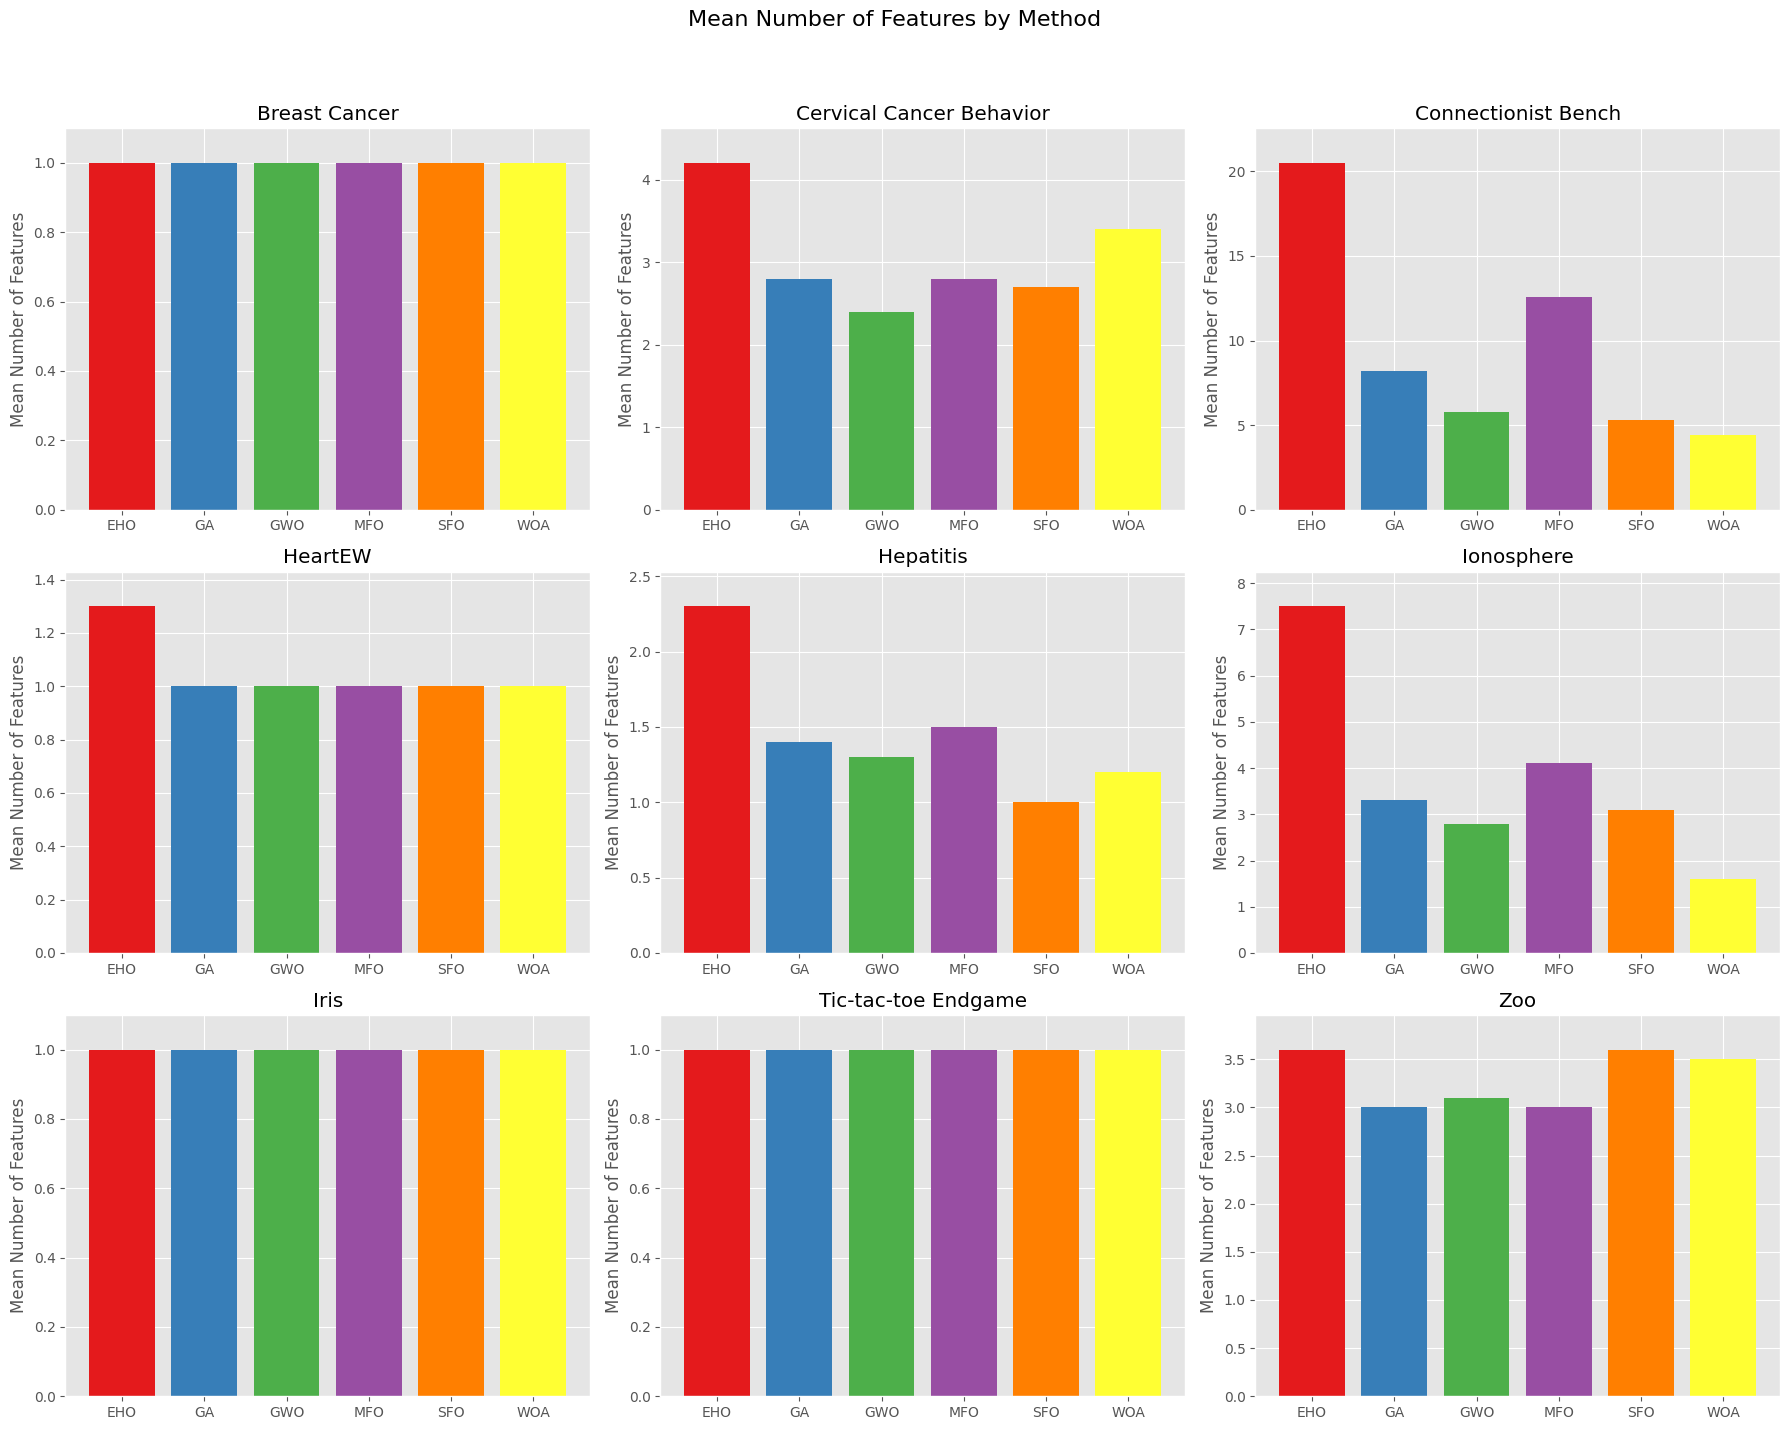

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Use the 'ggplot' plot style
plt.style.use('ggplot')

datasets = [
    {"name": "Breast Cancer", "csvfile": "Breast_cancer_results.csv"},
    {"name": "Cervical Cancer Behavior", "csvfile": "Cervical_cancer_behavior_risk_results.csv"},
    {"name": "Connectionist Bench", "csvfile": "Connectionist_bench_results.csv"},
    {"name": "HeartEW", "csvfile": "HeartEW_results.csv"},
    {"name": "Hepatitis", "csvfile": "Hepatitis_results.csv"},
    {"name": "Ionosphere", "csvfile": "Ionosphere_results.csv"},
    {"name": "Iris", "csvfile": "Iris_results.csv"},
    {"name": "Tic-tac-toe Endgame", "csvfile": "Tic-tac-toe_endgame_results.csv"},
    {"name": "Zoo", "csvfile": "Zoo_results.csv"},
]

# Collect all unique methods from all datasets
all_methods = set()
for dataset in datasets:
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    all_methods.update(df['Method'].unique())

# Generate a consistent color map for all methods using Set1 colormap
color_map = {method: color for method, color in zip(sorted(all_methods), plt.get_cmap('Set1').colors)}

# Create a figure with 9 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Mean Number of Features by Method', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and plot the results
for i, dataset in enumerate(datasets):
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    
    # Calculate the mean of 'Number of Features'
    grouped_df = df.groupby('Method').agg({
        'NumberOfFeatures': 'mean'
    }).reset_index()
    
    ax = axes[i]

    # Plot Number of Features with unique colors for each method
    bars = ax.bar(grouped_df['Method'], grouped_df['NumberOfFeatures'], color=[color_map[method] for method in grouped_df['Method']])
    ax.set_ylabel('Mean Number of Features')
    ax.set_title(dataset["name"])
    ax.set_ylim(0, grouped_df['NumberOfFeatures'].max() * 1.1)  # Set y-axis to 0-maximum number of features


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot as a PNG file
plt.savefig('mean_number_of_features_by_method.png')

# Show the plot
plt.show()


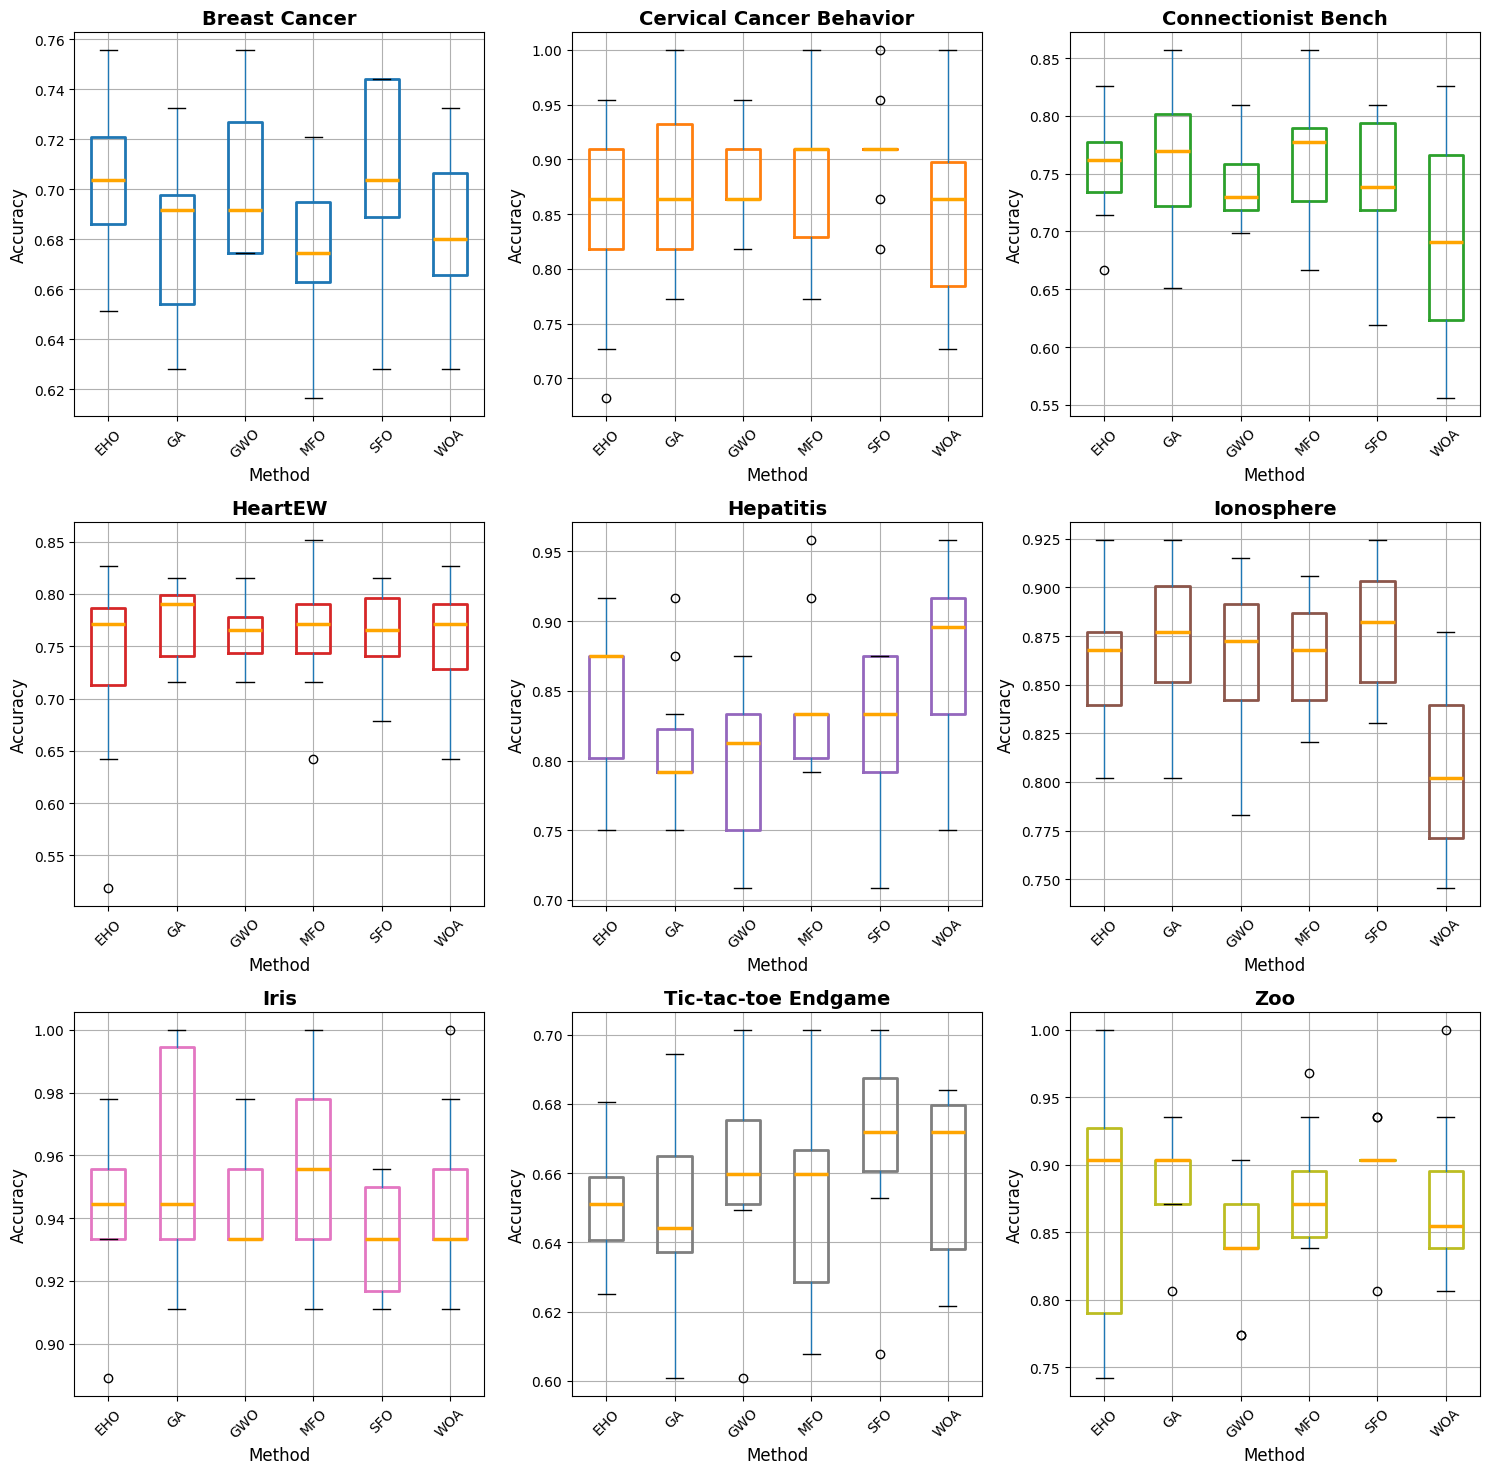

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Use a color palette suitable for publication
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

datasets = [
    {"name": "Breast Cancer", "csvfile": "Breast_cancer_results.csv"},
    {"name": "Cervical Cancer Behavior", "csvfile": "Cervical_cancer_behavior_risk_results.csv"},
    {"name": "Connectionist Bench", "csvfile": "Connectionist_bench_results.csv"},
    {"name": "HeartEW", "csvfile": "HeartEW_results.csv"},
    {"name": "Hepatitis", "csvfile": "Hepatitis_results.csv"},
    {"name": "Ionosphere", "csvfile": "Ionosphere_results.csv"},
    {"name": "Iris", "csvfile": "Iris_results.csv"},
    {"name": "Tic-tac-toe Endgame", "csvfile": "Tic-tac-toe_endgame_results.csv"},
    {"name": "Zoo", "csvfile": "Zoo_results.csv"},
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, dataset in enumerate(datasets):
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    ax = axes[i]
    # Box plot creation with a temporary plot to remove automatic titles
    df.boxplot(column='Accuracy', by='Method', ax=ax, boxprops=dict(linestyle='-', linewidth=2, color=colors[i % len(colors)]), 
               medianprops=dict(linestyle='-', linewidth=2.5, color='orange'))
    # Remove the automatic title added by pandas
    ax.set_title(dataset['name'], fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlabel('Method', fontsize=12)
    # Remove the automatic subtitle added by pandas
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.get_figure().suptitle('')  # Remove the default subtitle
    ax.tick_params(axis='x', rotation=45)

# Turn off any unused subplots
for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('mean_number_of_features_by_method.png')

plt.show()

## create tables

In [4]:
import pandas as pd

datasets = [
    {"name": "Breast Cancer", "csvfile": "Breast_cancer_results.csv"},
    {"name": "Cervical Cancer Behavior", "csvfile": "Cervical_cancer_behavior_risk_results.csv"},
    {"name": "Connectionist Bench", "csvfile": "Connectionist_bench_results.csv"},
    {"name": "HeartEW", "csvfile": "HeartEW_results.csv"},
    {"name": "Hepatitis", "csvfile": "Hepatitis_results.csv"},
    {"name": "Ionosphere", "csvfile": "Ionosphere_results.csv"},
    {"name": "Iris", "csvfile": "Iris_results.csv"},
    {"name": "Tic-tac-toe Endgame", "csvfile": "Tic-tac-toe_endgame_results.csv"},
    {"name": "Zoo", "csvfile": "Zoo_results.csv"},
]

# Initialize an empty dictionary to store results for each dataset
dataset_results = {}

# Iterate over datasets
for dataset in datasets:
    df = pd.read_csv(f"./results/{dataset['csvfile']}")
    
    # Initialize dictionaries to store accuracies for each method
    method_avg_accuracies = {}
    method_best_accuracies = {}

    # Iterate over each method
    for method in df['Method'].unique():
        method_df = df[df['Method'] == method]
        accuracies = method_df['NumberOfFeatures']
        
        # Calculate average accuracy
        avg_accuracy = accuracies.mean()
        method_avg_accuracies[method] = avg_accuracy
        
        # Calculate best accuracy
        best_accuracy = accuracies.min()
        method_best_accuracies[method] = best_accuracy

    # Create DataFrames for average and best accuracies
    avg_accuracy_df = pd.DataFrame.from_dict(method_avg_accuracies, orient='index', columns=['Average NumberOfFeatures'])
    best_accuracy_df = pd.DataFrame.from_dict(method_best_accuracies, orient='index', columns=['Best NumberOfFeatures'])
    
    # Merge DataFrames
    result_df = pd.concat([avg_accuracy_df, best_accuracy_df], axis=1)
    
    # Store results for this dataset
    dataset_results[dataset['name']] = result_df

# Print results for each dataset
for dataset_name, df in dataset_results.items():
    print(f"\nResults for {dataset_name}:")
    print(df)


Results for Breast Cancer:
     Average NumberOfFeatures  Best NumberOfFeatures
SFO                       1.0                      1
GA                        1.0                      1
EHO                       1.0                      1
GWO                       1.0                      1
WOA                       1.0                      1
MFO                       1.0                      1

Results for Cervical Cancer Behavior:
     Average NumberOfFeatures  Best NumberOfFeatures
SFO                       2.7                      2
GA                        2.8                      2
EHO                       4.2                      3
GWO                       2.4                      2
WOA                       3.4                      2
MFO                       2.8                      2

Results for Connectionist Bench:
     Average NumberOfFeatures  Best NumberOfFeatures
SFO                       5.3                      2
GA                        8.2                      